In [1]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=2ed94800be7492fd4ffbfd2c166bb97888274694930f281fb4114fc3e91f0077
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=8db7756537edb5a206d599a5546c054ea6c5690fa2d0fa1673c771536e3d2519
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [2]:
# this one uses 3*3 size filters
import numpy as np
import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["TORCH_USE_CUDA_DSA"] = "1"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import time
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

Visualize Image

Image resolution: 1280 x 720
Image resolution: 1280 x 720


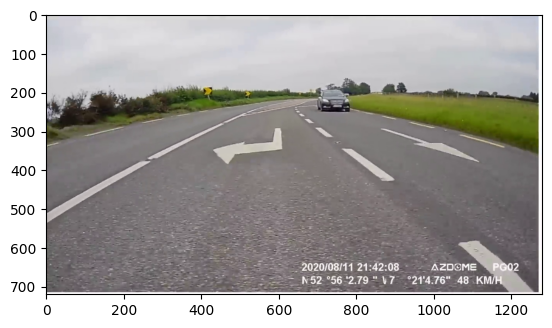

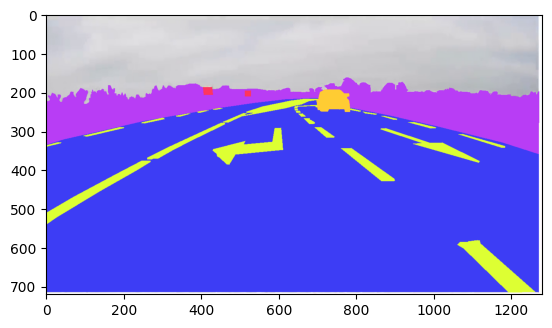

In [3]:
# Libraries you already have
import matplotlib.pyplot as plt
from PIL import Image

# Define the image path (replace with your actual working directory)
image_path = "/kaggle/input/roads-segmentation-dataset/images/0.png"
o_image_path = "/kaggle/input/roads-segmentation-dataset/masks/0.png"

# Read the image using PIL
img = Image.open(image_path)
o_img= Image.open(o_image_path)
width, height = img.size
print(f"Image resolution: {width} x {height}")
o_width, o_height = o_img.size
print(f"Image resolution: {o_width} x {o_height}")
# Display the image using matplotlib
plt.imshow(img)
plt.show()
plt.imshow(o_img)
plt.show()

In [4]:
#create list of images with and masks
images_path =  '/kaggle/input/roads-segmentation-dataset/images'
masks_path = '/kaggle/input/roads-segmentation-dataset/masks'

#loop over all the images in folders and create one to one mapping of images and masks
# {image:"path", mask:"path"}
image_paths = {}
mask_paths = {}
for item in os.listdir(images_path):
    item_path = os.path.join(images_path, item)
    filename = os.path.basename(item_path)
    file_stem = os.path.splitext(filename)[0]
    image_paths[int(file_stem)] = item_path

for item in os.listdir(masks_path):
    item_path = os.path.join(masks_path, item)
    filename = os.path.basename(item_path)
    file_stem = os.path.splitext(filename)[0]
    mask_paths[int(file_stem)] = item_path
print(image_paths[0])
print(mask_paths[0])

/kaggle/input/roads-segmentation-dataset/images/0.png
/kaggle/input/roads-segmentation-dataset/masks/0.png


In [5]:
color_map = {
    (61, 61, 245): 0,     # road_surface - blue
    (221,255,51): 1,      # marking      - green
    (255,204,51): 2,      # car          - yellow
    (255,53,94): 3,       # road_sign    - red
    (184,61,245): 4,       # background   - purple
    (0,0,0): 5 #sky - black
}

In [6]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, color_map, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.color_map = color_map  # Store the color map
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")
        mask = np.array(mask)
        mask = self.rgb_to_onehot(mask, self.color_map)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

    def rgb_to_onehot(self, rgb_image, color_map):
        """Converts an RGB image to a one-hot encoded image using a color map."""
        height, width, _ = rgb_image.shape
        num_classes = len(color_map)
        onehot_image = np.zeros((height, width, num_classes), dtype=np.float32)
        for h in range(height):
            for w in range(width):
                rgb = tuple(rgb_image[h, w])
                if rgb in color_map:
                    class_index = color_map[rgb]
                    onehot_image[h, w, class_index] = 1.0
                else:
                    onehot_image[h, w, 5] = 1.0 # Set to background class (RETYPED)
        return onehot_image
print("declared")

declared


In [7]:
# dataset = SegmentationDataset(transform=transforms.ToTensor())
# first_data = dataset[0]
# features, labels = first_data
# print(type(features), type(labels))

Transformations (including augmentations)

In [8]:
transform = transforms.Compose([transforms.ToTensor()])
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),  # Resize for consistent input size
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=20),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]),
}

In [9]:
batch_size = 4
# start_time = time.time()
# Split the dataset paths
image_train_paths, image_test_paths, mask_train_paths, mask_test_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)
# Create dataset instances using the split paths
train_dataset = SegmentationDataset(image_train_paths, mask_train_paths, color_map, transform=transform)
test_dataset = SegmentationDataset(image_test_paths, mask_test_paths, color_map, transform=transform)
# train_dataset = SegmentationDataset(image_train_paths, mask_train_paths, color_map, transform=data_transforms['train'])
# test_dataset = SegmentationDataset(image_test_paths, mask_test_paths, color_map, transform=data_transforms['test'])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("dataset loaded")
# print(train_loader)
# examples = iter(train_loader)
# print(examples)
# samples, labels = next(examples)

# print("Printing samples and shape")
# print(samples.shape, labels.shape)

dataset loaded


Simple U-NET

In [10]:
# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()

#         self.ds_conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
#         self.ds_pool1 = nn.MaxPool2d(2, stride=2)

#         self.ds_conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
#         self.ds_pool2 = nn.MaxPool2d(2, stride=2)

#         self.us_conv1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
#         self.us_upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

#         self.us_conv2 = nn.Conv2d(16, 5, kernel_size=3, padding=1)  # Output 5 channels
#         self.us_upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

#     def forward(self, x):
#         # Downsampling
#         x = self.ds_pool1(F.leaky_relu(self.ds_conv1(x)))
#         x = self.ds_pool2(F.leaky_relu(self.ds_conv2(x)))

#         # Upsampling
#         x = self.us_upsample1(F.leaky_relu(self.us_conv1(x)))
#         x = self.us_upsample2(F.leaky_relu(self.us_conv2(x)))

#         # x = torch.sigmoid(x) # no need of sigmoid CrossEntropyLoss applies it
        
#         return x

Batch Normalization

Batch normalization and leaky relu (earlier only 2 classes were getting recognized because of gradient loss due to sigmoid activation function)

In [11]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.ds_conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.ds_bn1 = nn.BatchNorm2d(16)  # Batch Normalization after conv1
        self.ds_pool1 = nn.MaxPool2d(2, stride=2)

        self.ds_conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.ds_bn2 = nn.BatchNorm2d(32)  # Batch Normalization after conv2
        self.ds_pool2 = nn.MaxPool2d(2, stride=2)

        self.us_conv1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.us_bn1 = nn.BatchNorm2d(16)  # Batch Normalization after us_conv1
        self.us_upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.us_conv2 = nn.Conv2d(16, 6, kernel_size=3, padding=1)
        self.us_bn2 = nn.BatchNorm2d(6)  # Batch Normalization after us_conv2
        self.us_upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Downsampling
        x = self.ds_conv1(x)
        x = self.ds_bn1(x)  # Apply Batch Norm
        x = F.leaky_relu(x) # Apply activation after batch norm
        x = self.ds_pool1(x)

        x = self.ds_conv2(x)
        x = self.ds_bn2(x)  # Apply Batch Norm
        x = F.leaky_relu(x) # Apply activation after batch norm
        x = self.ds_pool2(x)

        # Upsampling
        x = self.us_upsample1(x)
        x = self.us_conv1(x)
        x = self.us_bn1(x)  # Apply Batch Norm
        x = F.leaky_relu(x) # Apply activation after batch norm

        x = self.us_upsample2(x)
        x = self.us_conv2(x)
        x = self.us_bn2(x)  # Apply Batch Norm
        x = F.leaky_relu(x) # Apply activation after batch norm

        return x

A proper U-NET - with skip connections. Earlier max of 3 classes were working fine at a time. min loss seen was 0.1

In [12]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Downsampling path
        self.ds_conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.ds_bn1 = nn.BatchNorm2d(16)
        self.ds_pool1 = nn.MaxPool2d(2, stride=2)

        self.ds_conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.ds_bn2 = nn.BatchNorm2d(32)
        self.ds_pool2 = nn.MaxPool2d(2, stride=2)

        # Bottleneck (bottom of the U)
        self.bottleneck_conv = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bottleneck_bn = nn.BatchNorm2d(64)

        # Upsampling path
        self.us_upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.us_conv1 = nn.Conv2d(64 + 32, 32, kernel_size=3, padding=1) # skip connection 1
        self.us_bn1 = nn.BatchNorm2d(32)

        self.us_upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.us_conv2 = nn.Conv2d(32 + 16, 16, kernel_size=3, padding=1) # skip connection 2
        self.us_bn2 = nn.BatchNorm2d(16)

        self.final_conv = nn.Conv2d(16, 6, kernel_size=1)  # 1x1 convolution for output

    def forward(self, x):
        # Downsampling
        down1 = F.leaky_relu(self.ds_bn1(self.ds_conv1(x)))
        x = self.ds_pool1(down1)

        down2 = F.leaky_relu(self.ds_bn2(self.ds_conv2(x)))
        x = self.ds_pool2(down2)

        # Bottleneck
        x = F.leaky_relu(self.bottleneck_bn(self.bottleneck_conv(x)))

        # Upsampling with skip connections (concatenation)
        x = self.us_upsample1(x)
        x = torch.cat([x, down2], dim=1)  # Concatenate with corresponding downsampling feature map
        x = F.leaky_relu(self.us_bn1(self.us_conv1(x)))

        x = self.us_upsample2(x)
        x = torch.cat([x, down1], dim=1)  # Concatenate with corresponding downsampling feature map
        x = F.leaky_relu(self.us_bn2(self.us_conv2(x)))

        x = self.final_conv(x) # Final 1x1 conv layer
        return x

In [13]:
model = UNet().to(device)
# criterion = smp.losses.DiceLoss(mode = "multiclass", classes = 6, ignore_index = -1)
criterion = smp.losses.DiceLoss(mode = "multiclass", classes = 6)
# criterion = nn.CrossEntropyLoss()
# criterion = sm.losses.DiceLoss()
print(model.parameters())
optimizer = torch.optim.AdamW(model.parameters(), lr=.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0001, amsgrad=True)
n_total_steps = len(train_loader)

<generator object Module.parameters at 0x79030197b680>


In [14]:
def display_tensor_image(tensor):
    """Displays a PyTorch tensor as an image using matplotlib."""
    # Check if the tensor is on the GPU and move to CPU if necessary
    if tensor.is_cuda:
        tensor = tensor.cpu()

    # If it's a batch of images, display the first one
    if tensor.ndim == 4:
        tensor = tensor[0]  # Take the first image in the batch

    # If it has a channel dimension, permute it to (H, W, C)
    if tensor.ndim == 3:
      if tensor.shape[0] == 3:
        tensor = tensor.permute(1, 2, 0)

    # Convert to NumPy array and ensure correct data type
    img = tensor.numpy().astype(np.uint8)

    # Display the image using matplotlib
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

In [15]:
def index_to_rgb(outputs, color_map):
    #print(outputs)
    """Converts a model output tensor (class indices) to RGB images.

    Args:
        outputs (torch.Tensor): The model output tensor of shape (batch_size, num_classes, H, W).
        color_map (dict): A dictionary mapping RGB tuples to class indices.

    Returns:
        torch.Tensor: A tensor of shape (batch_size, 3, H, W) representing the RGB images, or None if there's an issue.
    """
    if not isinstance(outputs, torch.Tensor):
      print("outputs is not a tensor")
      return None
    if not isinstance(color_map, dict):
      print("color_map is not a dict")
      return None
    if len(outputs.shape)!=4:
      print("output shape is not correct")
      return None
    try:
        batch_size, num_classes, h, w = outputs.shape
        # print("batch_size, num_classes, h, w:",batch_size, num_classes, h, w)
    except ValueError:
        print("Invalid output shape. Expected (batch_size, num_classes, H, W).")
        return None

    color_map_expanded = list(color_map.items()) # Convert to list for indexing

    rgb_images = torch.zeros((batch_size, 3, h, w), dtype=torch.uint8, device=outputs.device)

    predicted_indices = torch.argmax(outputs, dim=1)  # Shape: (batch_size, H, W)
    # print("batchsie and colormapexpanded")
    # print(batch_size)
    # print(color_map_expanded)
    # print("argmax:",predicted_indices.shape," :",predicted_indices)
    for b in range(batch_size):
        for c, (color, index) in enumerate(color_map_expanded):
            # print("c: ",c, (color, index))
            mask = predicted_indices[b] == index
            rgb_images[b, :, mask] = torch.tensor(color, dtype=torch.uint8, device=outputs.device).view(3, 1)

    return rgb_images

device cuda


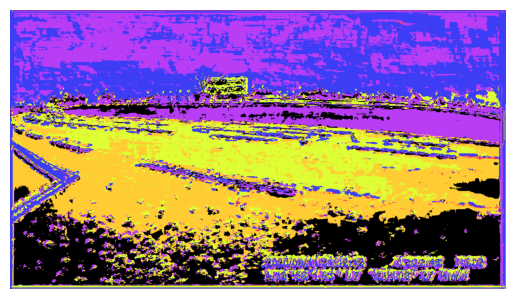

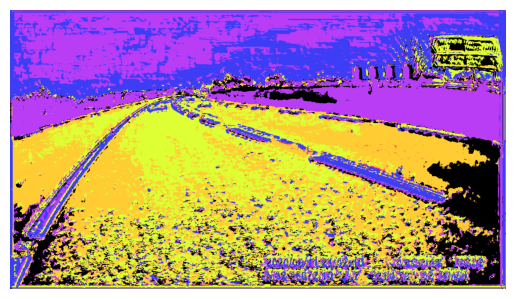

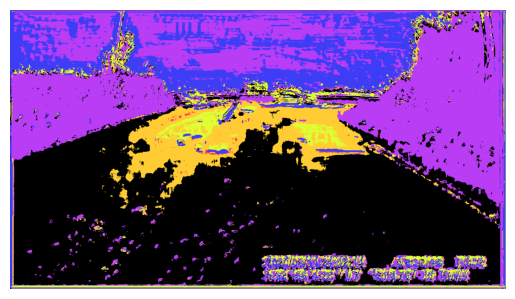

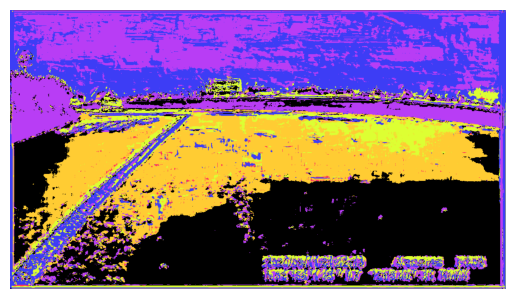

This is epoch 1/60, step 1/6, loss = 0.8832
This is epoch 1/60, step 2/6, loss = 0.8236
This is epoch 1/60, step 3/6, loss = 0.7999
This is epoch 1/60, step 4/6, loss = 0.7891
This is epoch 1/60, step 5/6, loss = 0.7887


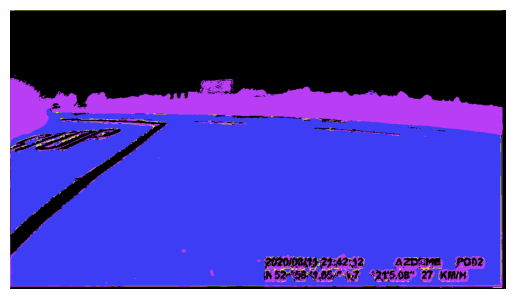

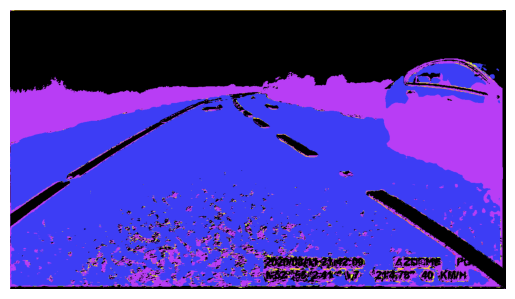

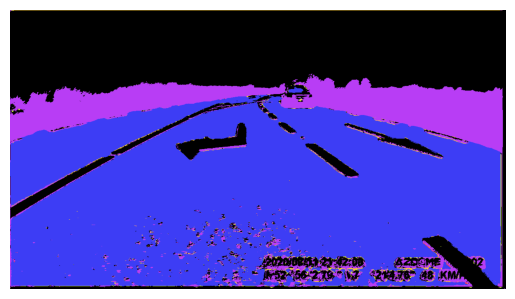

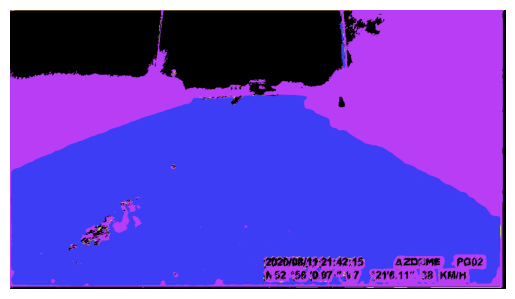

This is epoch 1/60, step 6/6, loss = 0.7783
This is epoch 2/60, step 1/6, loss = 0.7727
This is epoch 2/60, step 2/6, loss = 0.7732
This is epoch 2/60, step 3/6, loss = 0.7644
This is epoch 2/60, step 4/6, loss = 0.7635
This is epoch 2/60, step 5/6, loss = 0.7552
This is epoch 2/60, step 6/6, loss = 0.7540
This is epoch 3/60, step 1/6, loss = 0.7493
This is epoch 3/60, step 2/6, loss = 0.7428
This is epoch 3/60, step 3/6, loss = 0.7461
This is epoch 3/60, step 4/6, loss = 0.7401
This is epoch 3/60, step 5/6, loss = 0.7475
This is epoch 3/60, step 6/6, loss = 0.7424
This is epoch 4/60, step 1/6, loss = 0.7325
This is epoch 4/60, step 2/6, loss = 0.7334
This is epoch 4/60, step 3/6, loss = 0.7329
This is epoch 4/60, step 4/6, loss = 0.7323
This is epoch 4/60, step 5/6, loss = 0.7250
This is epoch 4/60, step 6/6, loss = 0.7207
This is epoch 5/60, step 1/6, loss = 0.7325
This is epoch 5/60, step 2/6, loss = 0.7210
This is epoch 5/60, step 3/6, loss = 0.5607
This is epoch 5/60, step 4/6, lo

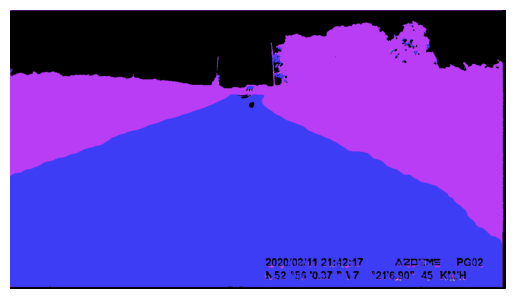

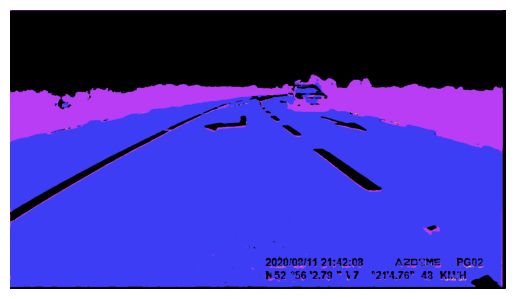

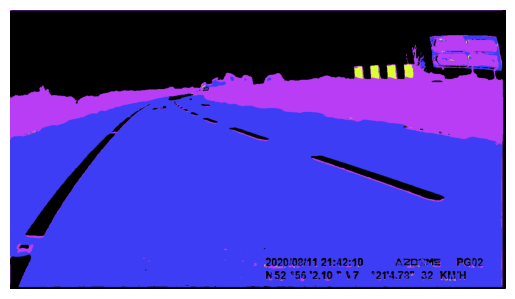

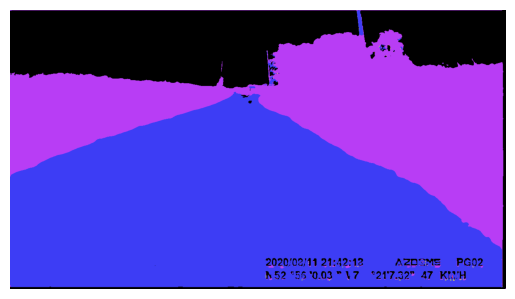

This is epoch 6/60, step 1/6, loss = 0.7071
This is epoch 6/60, step 2/6, loss = 0.7047
This is epoch 6/60, step 3/6, loss = 0.7163
This is epoch 6/60, step 4/6, loss = 0.7007
This is epoch 6/60, step 5/6, loss = 0.7012


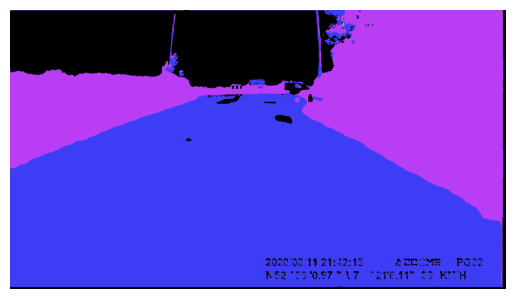

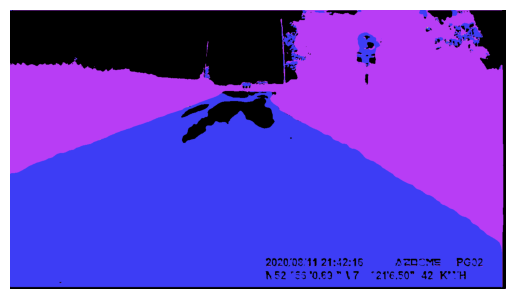

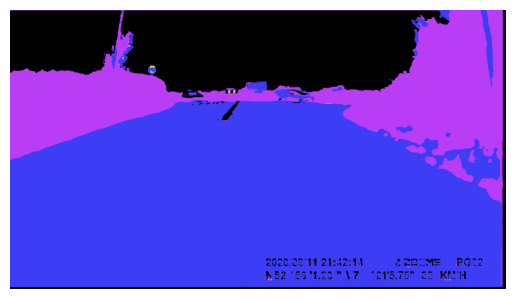

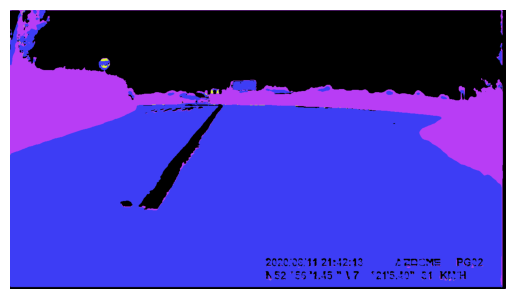

This is epoch 6/60, step 6/6, loss = 0.7033
This is epoch 7/60, step 1/6, loss = 0.6925
This is epoch 7/60, step 2/6, loss = 0.6914
This is epoch 7/60, step 3/6, loss = 0.6904
This is epoch 7/60, step 4/6, loss = 0.6835
This is epoch 7/60, step 5/6, loss = 0.6888
This is epoch 7/60, step 6/6, loss = 0.6835
This is epoch 8/60, step 1/6, loss = 0.6854
This is epoch 8/60, step 2/6, loss = 0.6780
This is epoch 8/60, step 3/6, loss = 0.6747
This is epoch 8/60, step 4/6, loss = 0.6738
This is epoch 8/60, step 5/6, loss = 0.6689
This is epoch 8/60, step 6/6, loss = 0.6686
This is epoch 9/60, step 1/6, loss = 0.6665
This is epoch 9/60, step 2/6, loss = 0.6622
This is epoch 9/60, step 3/6, loss = 0.6617
This is epoch 9/60, step 4/6, loss = 0.6599
This is epoch 9/60, step 5/6, loss = 0.6594
This is epoch 9/60, step 6/6, loss = 0.6590
This is epoch 10/60, step 1/6, loss = 0.6512
This is epoch 10/60, step 2/6, loss = 0.6498
This is epoch 10/60, step 3/6, loss = 0.6498
This is epoch 10/60, step 4/6

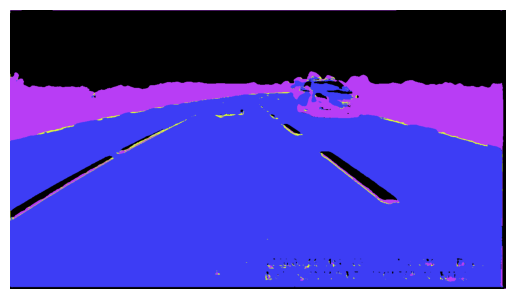

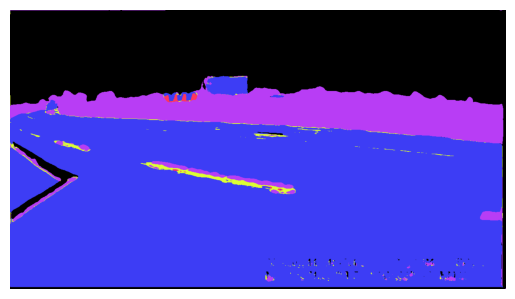

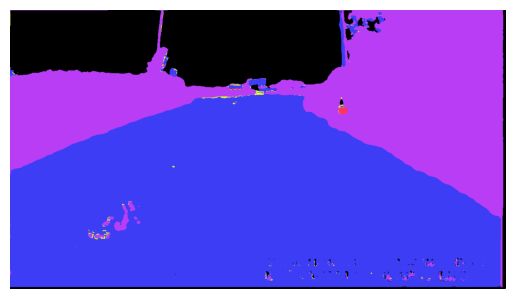

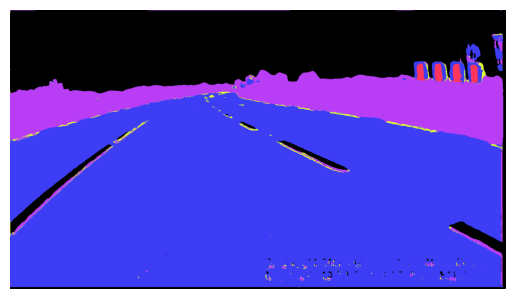

This is epoch 11/60, step 1/6, loss = 0.6428
This is epoch 11/60, step 2/6, loss = 0.6433
This is epoch 11/60, step 3/6, loss = 0.6360
This is epoch 11/60, step 4/6, loss = 0.6359
This is epoch 11/60, step 5/6, loss = 0.6295


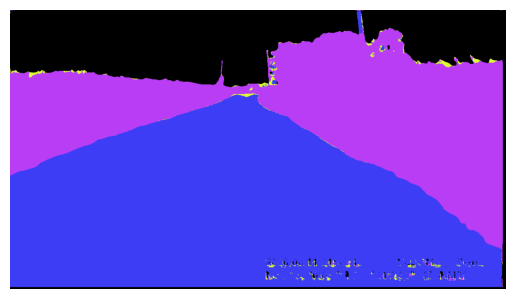

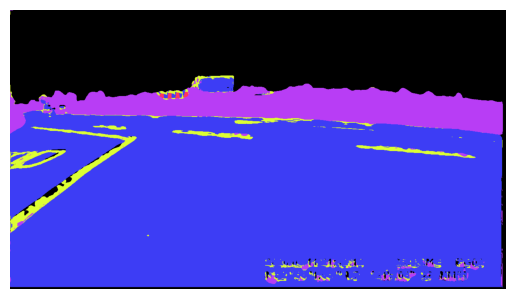

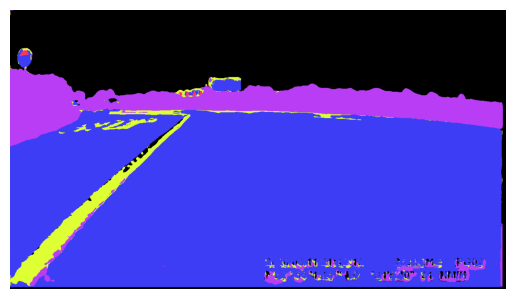

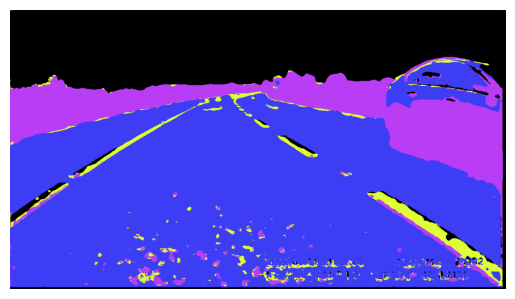

This is epoch 11/60, step 6/6, loss = 0.6304
This is epoch 12/60, step 1/6, loss = 0.6238
This is epoch 12/60, step 2/6, loss = 0.6317
This is epoch 12/60, step 3/6, loss = 0.6151
This is epoch 12/60, step 4/6, loss = 0.6244
This is epoch 12/60, step 5/6, loss = 0.6129
This is epoch 12/60, step 6/6, loss = 0.6146
This is epoch 13/60, step 1/6, loss = 0.6075
This is epoch 13/60, step 2/6, loss = 0.6066
This is epoch 13/60, step 3/6, loss = 0.6137
This is epoch 13/60, step 4/6, loss = 0.6155
This is epoch 13/60, step 5/6, loss = 0.6092
This is epoch 13/60, step 6/6, loss = 0.6003
This is epoch 14/60, step 1/6, loss = 0.5940
This is epoch 14/60, step 2/6, loss = 0.5828
This is epoch 14/60, step 3/6, loss = 0.5716
This is epoch 14/60, step 4/6, loss = 0.6267
This is epoch 14/60, step 5/6, loss = 0.5781
This is epoch 14/60, step 6/6, loss = 0.5805
This is epoch 15/60, step 1/6, loss = 0.5747
This is epoch 15/60, step 2/6, loss = 0.5725
This is epoch 15/60, step 3/6, loss = 0.5601
This is ep

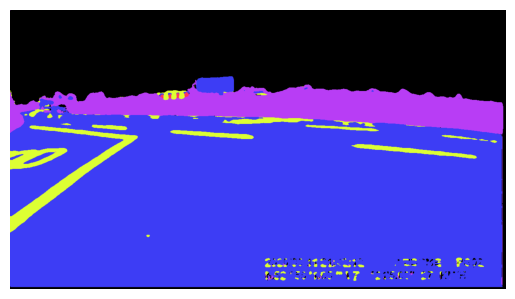

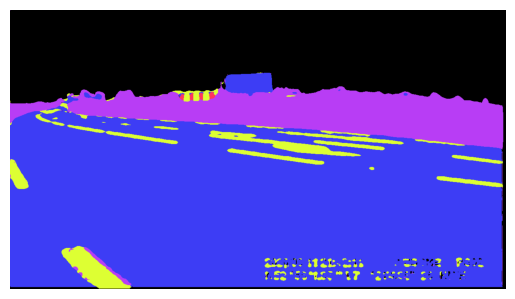

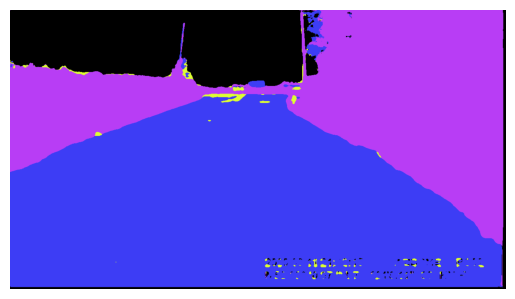

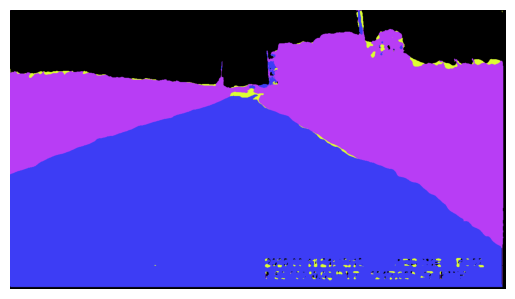

This is epoch 16/60, step 1/6, loss = 0.5615
This is epoch 16/60, step 2/6, loss = 0.5507
This is epoch 16/60, step 3/6, loss = 0.5462
This is epoch 16/60, step 4/6, loss = 0.5470
This is epoch 16/60, step 5/6, loss = 0.5659


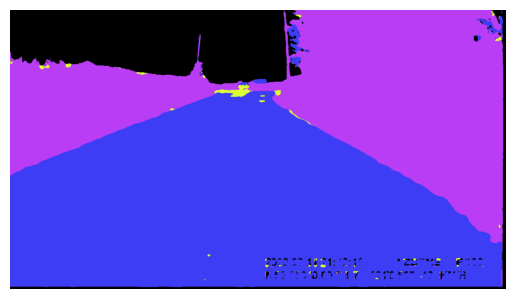

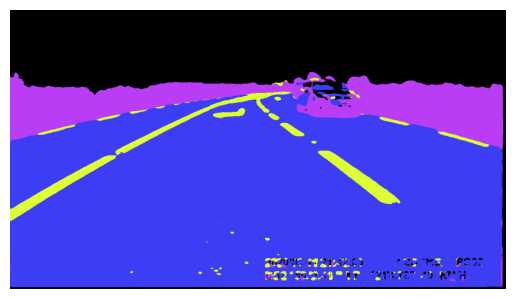

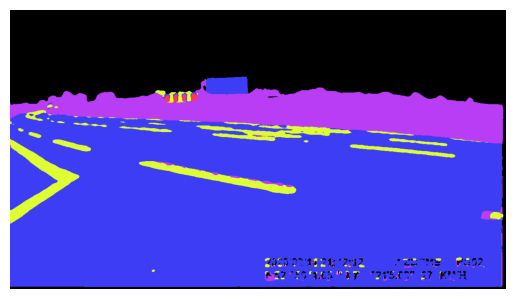

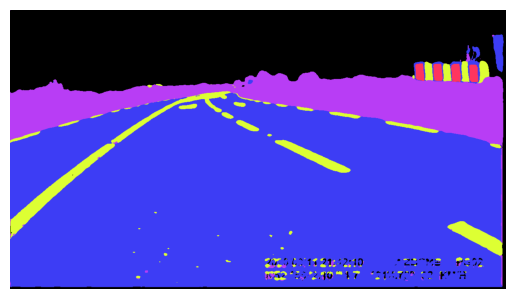

This is epoch 16/60, step 6/6, loss = 0.5390
This is epoch 17/60, step 1/6, loss = 0.5541
This is epoch 17/60, step 2/6, loss = 0.5586
This is epoch 17/60, step 3/6, loss = 0.5960
This is epoch 17/60, step 4/6, loss = 0.5551
This is epoch 17/60, step 5/6, loss = 0.5520
This is epoch 17/60, step 6/6, loss = 0.5380
This is epoch 18/60, step 1/6, loss = 0.5417
This is epoch 18/60, step 2/6, loss = 0.5600
This is epoch 18/60, step 3/6, loss = 0.5289
This is epoch 18/60, step 4/6, loss = 0.5369
This is epoch 18/60, step 5/6, loss = 0.5155
This is epoch 18/60, step 6/6, loss = 0.5319
This is epoch 19/60, step 1/6, loss = 0.5502
This is epoch 19/60, step 2/6, loss = 0.5052
This is epoch 19/60, step 3/6, loss = 0.4986
This is epoch 19/60, step 4/6, loss = 0.5194
This is epoch 19/60, step 5/6, loss = 0.5143
This is epoch 19/60, step 6/6, loss = 0.5114
This is epoch 20/60, step 1/6, loss = 0.5103
This is epoch 20/60, step 2/6, loss = 0.4916
This is epoch 20/60, step 3/6, loss = 0.4948
This is ep

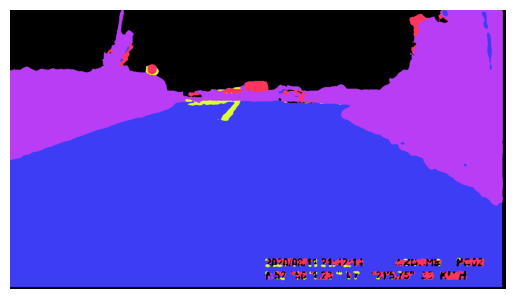

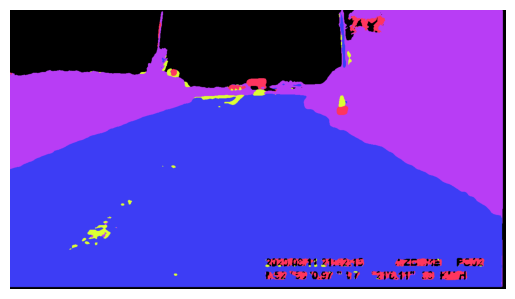

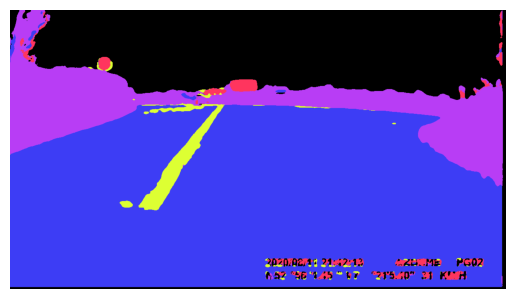

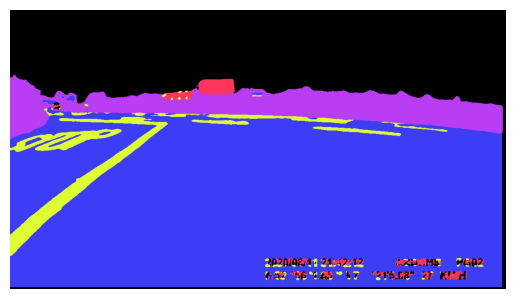

This is epoch 21/60, step 1/6, loss = 0.5066
This is epoch 21/60, step 2/6, loss = 0.4801
This is epoch 21/60, step 3/6, loss = 0.4795
This is epoch 21/60, step 4/6, loss = 0.4874
This is epoch 21/60, step 5/6, loss = 0.5171


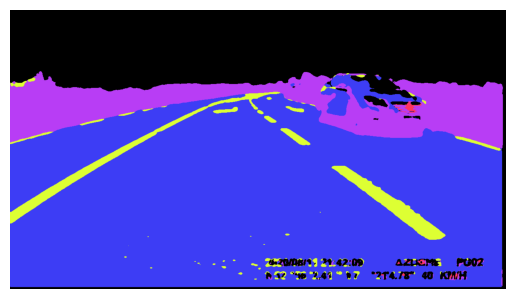

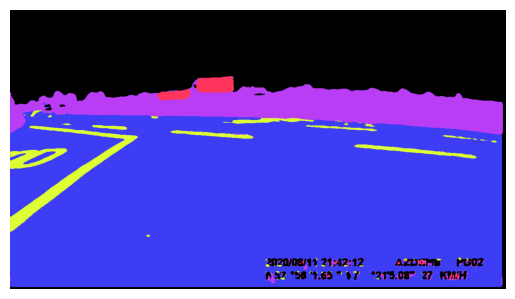

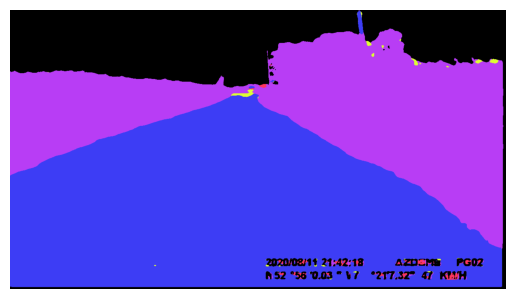

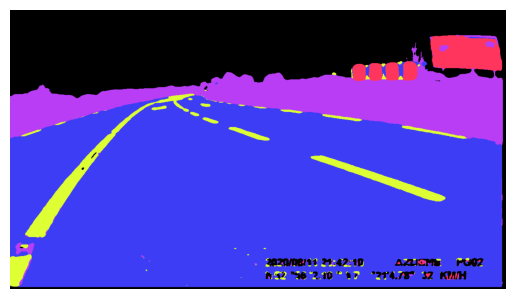

This is epoch 21/60, step 6/6, loss = 0.4613
This is epoch 22/60, step 1/6, loss = 0.5136
This is epoch 22/60, step 2/6, loss = 0.4732
This is epoch 22/60, step 3/6, loss = 0.4740
This is epoch 22/60, step 4/6, loss = 0.4537
This is epoch 22/60, step 5/6, loss = 0.5253
This is epoch 22/60, step 6/6, loss = 0.4447
This is epoch 23/60, step 1/6, loss = 0.4983
This is epoch 23/60, step 2/6, loss = 0.4504
This is epoch 23/60, step 3/6, loss = 0.4399
This is epoch 23/60, step 4/6, loss = 0.4390
This is epoch 23/60, step 5/6, loss = 0.4562
This is epoch 23/60, step 6/6, loss = 0.4558
This is epoch 24/60, step 1/6, loss = 0.4368
This is epoch 24/60, step 2/6, loss = 0.4463
This is epoch 24/60, step 3/6, loss = 0.4467
This is epoch 24/60, step 4/6, loss = 0.4669
This is epoch 24/60, step 5/6, loss = 0.4414
This is epoch 24/60, step 6/6, loss = 0.4227
This is epoch 25/60, step 1/6, loss = 0.4386
This is epoch 25/60, step 2/6, loss = 0.4181
This is epoch 25/60, step 3/6, loss = 0.4177
This is ep

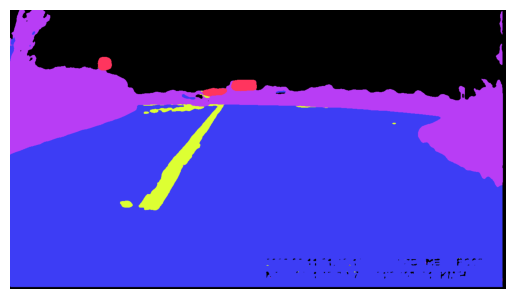

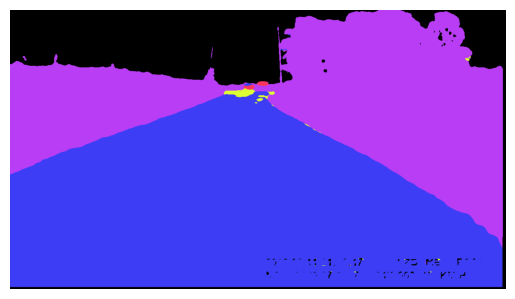

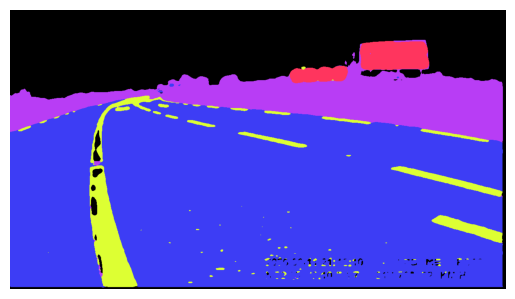

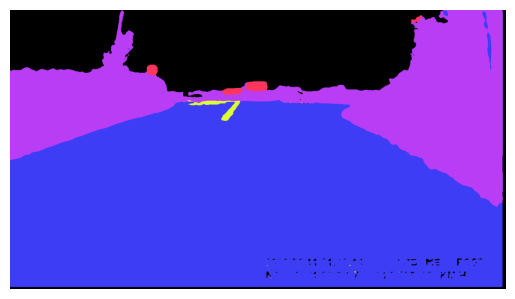

This is epoch 26/60, step 1/6, loss = 0.4098
This is epoch 26/60, step 2/6, loss = 0.4215
This is epoch 26/60, step 3/6, loss = 0.4028
This is epoch 26/60, step 4/6, loss = 0.3790
This is epoch 26/60, step 5/6, loss = 0.4213


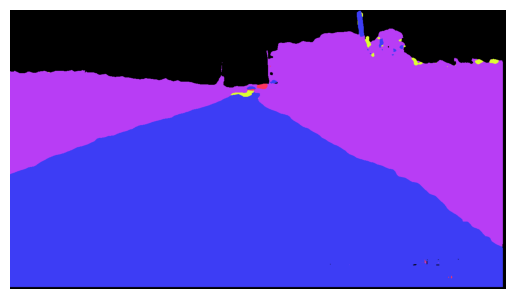

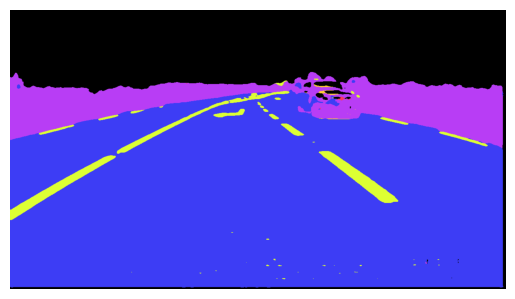

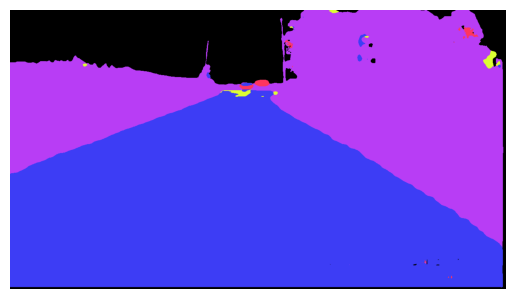

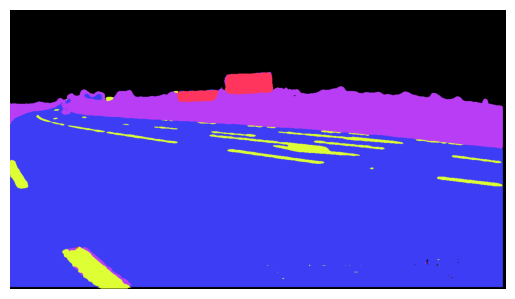

This is epoch 26/60, step 6/6, loss = 0.4190
This is epoch 27/60, step 1/6, loss = 0.4429
This is epoch 27/60, step 2/6, loss = 0.3729
This is epoch 27/60, step 3/6, loss = 0.3980
This is epoch 27/60, step 4/6, loss = 0.4087
This is epoch 27/60, step 5/6, loss = 0.4001
This is epoch 27/60, step 6/6, loss = 0.3872
This is epoch 28/60, step 1/6, loss = 0.3900
This is epoch 28/60, step 2/6, loss = 0.4349
This is epoch 28/60, step 3/6, loss = 0.4062
This is epoch 28/60, step 4/6, loss = 0.3773
This is epoch 28/60, step 5/6, loss = 0.3904
This is epoch 28/60, step 6/6, loss = 0.3926
This is epoch 29/60, step 1/6, loss = 0.3591
This is epoch 29/60, step 2/6, loss = 0.3850
This is epoch 29/60, step 3/6, loss = 0.3961
This is epoch 29/60, step 4/6, loss = 0.3852
This is epoch 29/60, step 5/6, loss = 0.3610
This is epoch 29/60, step 6/6, loss = 0.3729
This is epoch 30/60, step 1/6, loss = 0.3615
This is epoch 30/60, step 2/6, loss = 0.3368
This is epoch 30/60, step 3/6, loss = 0.3688
This is ep

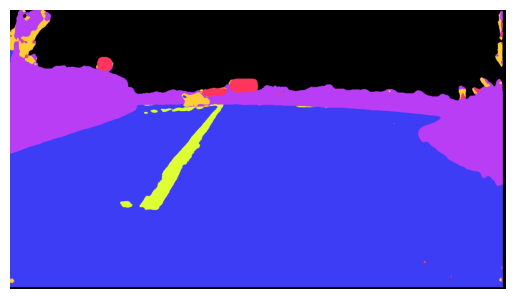

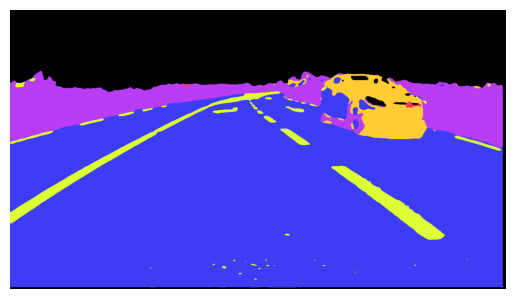

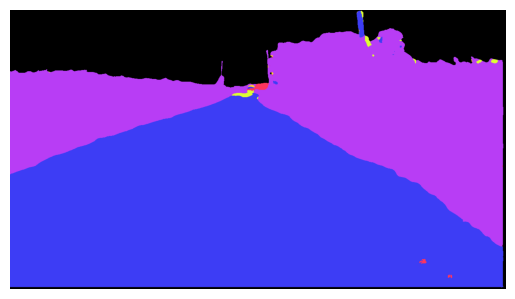

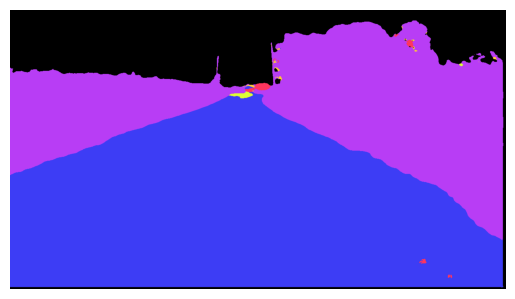

This is epoch 31/60, step 1/6, loss = 0.3609
This is epoch 31/60, step 2/6, loss = 0.3199
This is epoch 31/60, step 3/6, loss = 0.3362
This is epoch 31/60, step 4/6, loss = 0.2947
This is epoch 31/60, step 5/6, loss = 0.3340


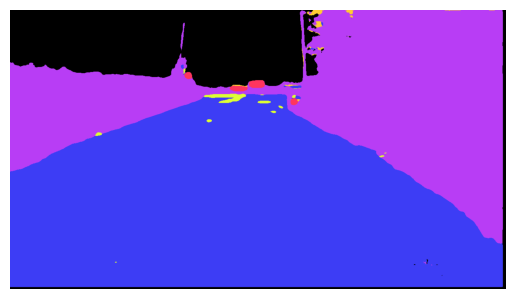

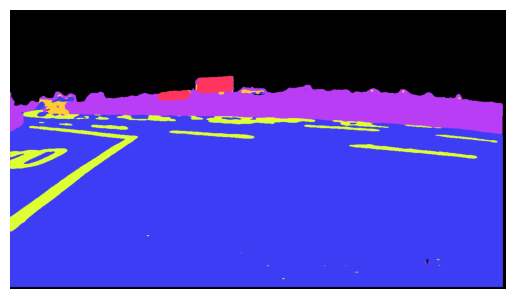

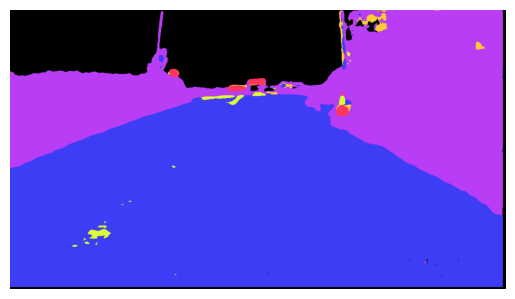

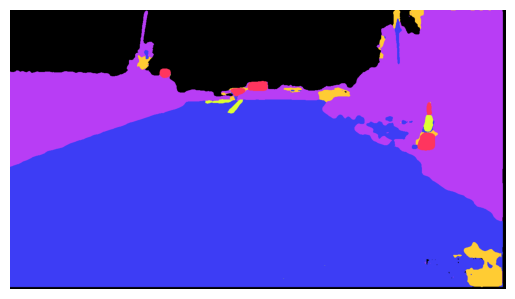

This is epoch 31/60, step 6/6, loss = 0.3872
This is epoch 32/60, step 1/6, loss = 0.2895
This is epoch 32/60, step 2/6, loss = 0.3443
This is epoch 32/60, step 3/6, loss = 0.3030
This is epoch 32/60, step 4/6, loss = 0.3455
This is epoch 32/60, step 5/6, loss = 0.2921
This is epoch 32/60, step 6/6, loss = 0.2958
This is epoch 33/60, step 1/6, loss = 0.3397
This is epoch 33/60, step 2/6, loss = 0.2870
This is epoch 33/60, step 3/6, loss = 0.2847
This is epoch 33/60, step 4/6, loss = 0.4063
This is epoch 33/60, step 5/6, loss = 0.3562
This is epoch 33/60, step 6/6, loss = 0.2995
This is epoch 34/60, step 1/6, loss = 0.3675
This is epoch 34/60, step 2/6, loss = 0.3027
This is epoch 34/60, step 3/6, loss = 0.3450
This is epoch 34/60, step 4/6, loss = 0.2308
This is epoch 34/60, step 5/6, loss = 0.2501
This is epoch 34/60, step 6/6, loss = 0.2460
This is epoch 35/60, step 1/6, loss = 0.3188
This is epoch 35/60, step 2/6, loss = 0.2906
This is epoch 35/60, step 3/6, loss = 0.2962
This is ep

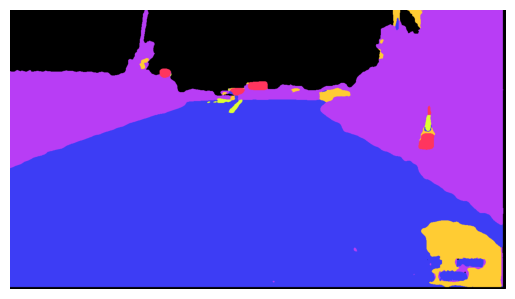

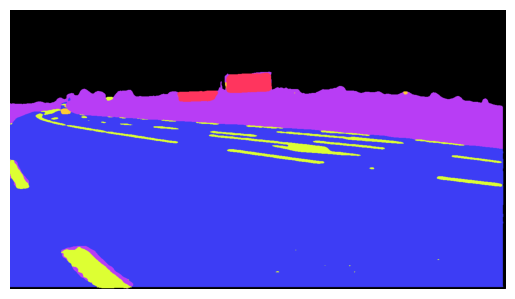

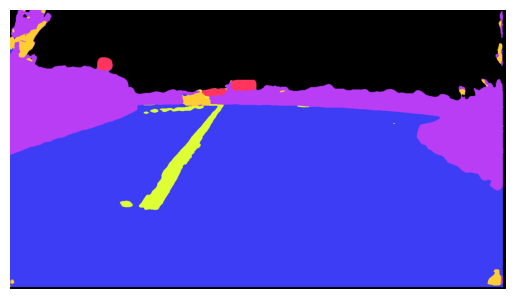

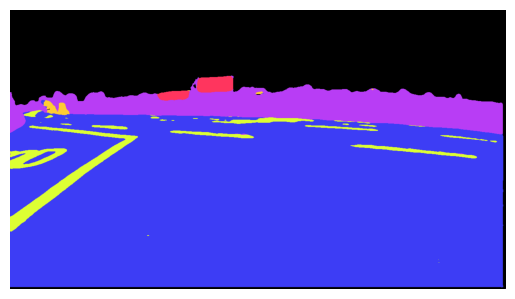

This is epoch 36/60, step 1/6, loss = 0.2863
This is epoch 36/60, step 2/6, loss = 0.2462
This is epoch 36/60, step 3/6, loss = 0.1904
This is epoch 36/60, step 4/6, loss = 0.2605
This is epoch 36/60, step 5/6, loss = 0.3256


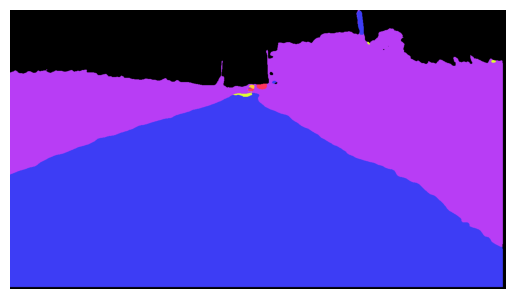

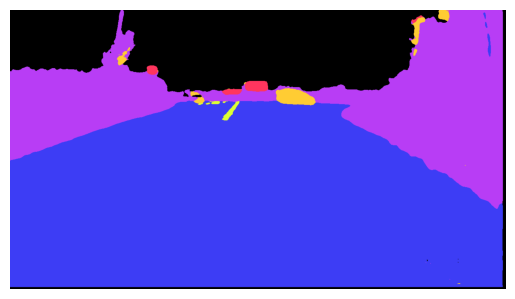

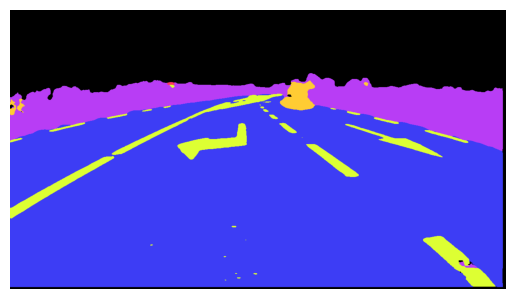

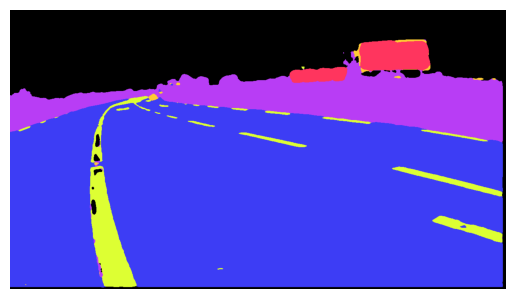

This is epoch 36/60, step 6/6, loss = 0.2328
This is epoch 37/60, step 1/6, loss = 0.2716
This is epoch 37/60, step 2/6, loss = 0.2516
This is epoch 37/60, step 3/6, loss = 0.2517
This is epoch 37/60, step 4/6, loss = 0.2642
This is epoch 37/60, step 5/6, loss = 0.2414
This is epoch 37/60, step 6/6, loss = 0.2265
This is epoch 38/60, step 1/6, loss = 0.2667
This is epoch 38/60, step 2/6, loss = 0.1990
This is epoch 38/60, step 3/6, loss = 0.2452
This is epoch 38/60, step 4/6, loss = 0.2812
This is epoch 38/60, step 5/6, loss = 0.2487
This is epoch 38/60, step 6/6, loss = 0.2563
This is epoch 39/60, step 1/6, loss = 0.3035
This is epoch 39/60, step 2/6, loss = 0.2009
This is epoch 39/60, step 3/6, loss = 0.2210
This is epoch 39/60, step 4/6, loss = 0.2315
This is epoch 39/60, step 5/6, loss = 0.2432
This is epoch 39/60, step 6/6, loss = 0.1910
This is epoch 40/60, step 1/6, loss = 0.2400
This is epoch 40/60, step 2/6, loss = 0.2331
This is epoch 40/60, step 3/6, loss = 0.2086
This is ep

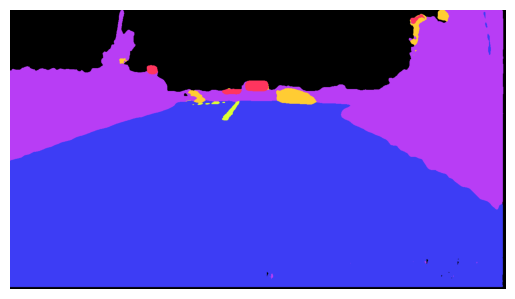

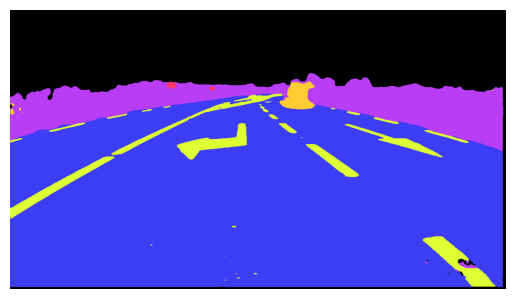

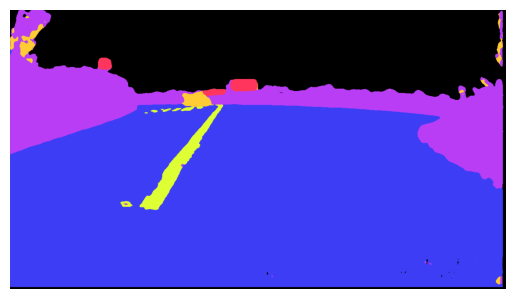

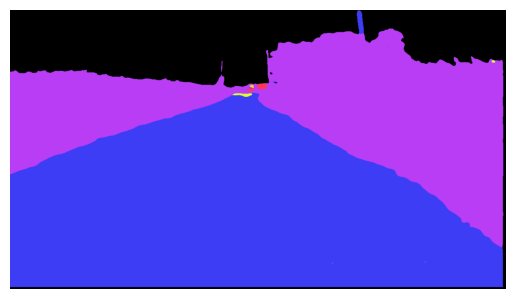

This is epoch 41/60, step 1/6, loss = 0.2235
This is epoch 41/60, step 2/6, loss = 0.2430
This is epoch 41/60, step 3/6, loss = 0.2246
This is epoch 41/60, step 4/6, loss = 0.4267
This is epoch 41/60, step 5/6, loss = 0.2024


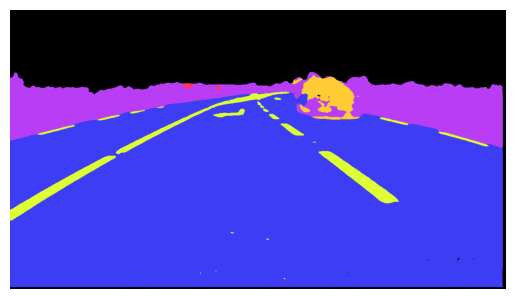

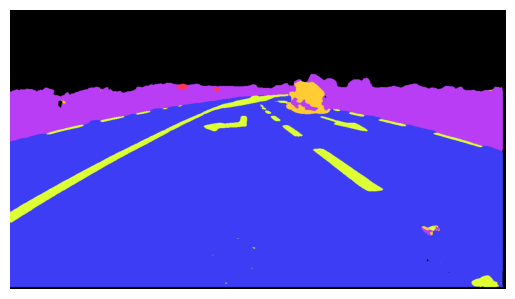

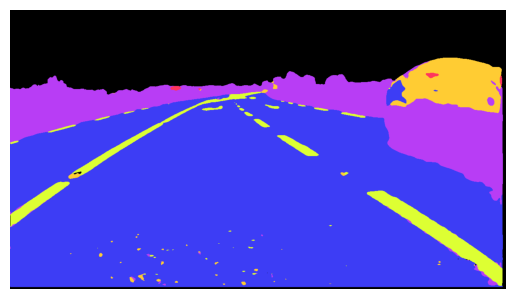

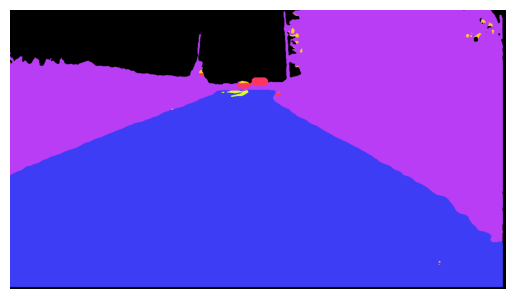

This is epoch 41/60, step 6/6, loss = 0.2446
This is epoch 42/60, step 1/6, loss = 0.1898
This is epoch 42/60, step 2/6, loss = 0.2605
This is epoch 42/60, step 3/6, loss = 0.2372
This is epoch 42/60, step 4/6, loss = 0.1446
This is epoch 42/60, step 5/6, loss = 0.1645
This is epoch 42/60, step 6/6, loss = 0.2462
This is epoch 43/60, step 1/6, loss = 0.1762
This is epoch 43/60, step 2/6, loss = 0.2209
This is epoch 43/60, step 3/6, loss = 0.1449
This is epoch 43/60, step 4/6, loss = 0.2166
This is epoch 43/60, step 5/6, loss = 0.2015
This is epoch 43/60, step 6/6, loss = 0.1877
This is epoch 44/60, step 1/6, loss = 0.1485
This is epoch 44/60, step 2/6, loss = 0.1709
This is epoch 44/60, step 3/6, loss = 0.2746
This is epoch 44/60, step 4/6, loss = 0.2013
This is epoch 44/60, step 5/6, loss = 0.1669
This is epoch 44/60, step 6/6, loss = 0.2506
This is epoch 45/60, step 1/6, loss = 0.1891
This is epoch 45/60, step 2/6, loss = 0.1657
This is epoch 45/60, step 3/6, loss = 0.2195
This is ep

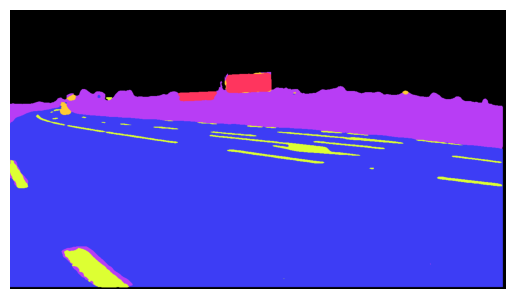

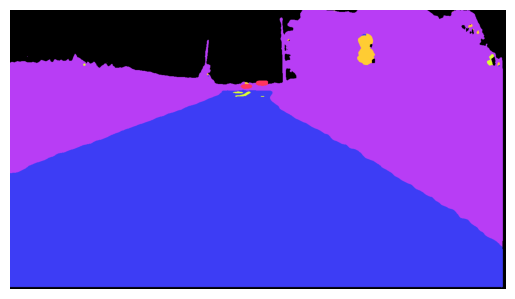

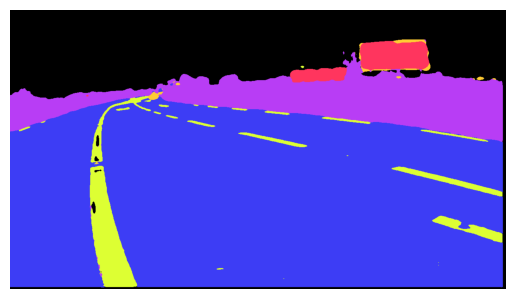

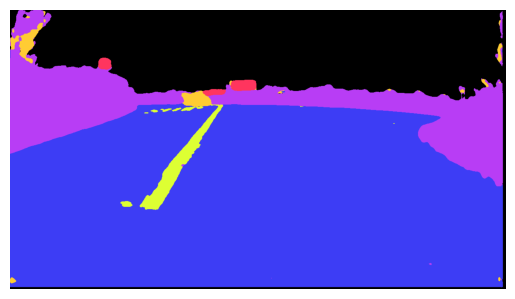

This is epoch 46/60, step 1/6, loss = 0.1947
This is epoch 46/60, step 2/6, loss = 0.1636
This is epoch 46/60, step 3/6, loss = 0.1359
This is epoch 46/60, step 4/6, loss = 0.1401
This is epoch 46/60, step 5/6, loss = 0.1802


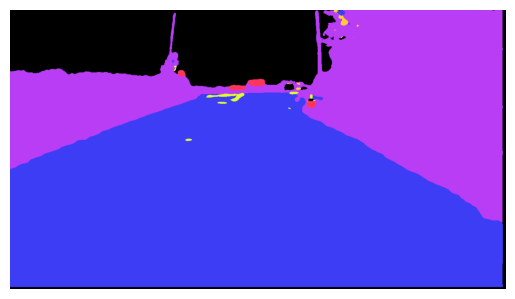

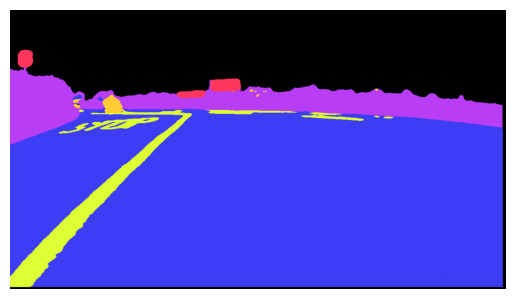

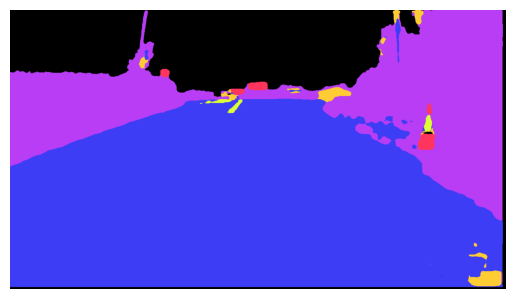

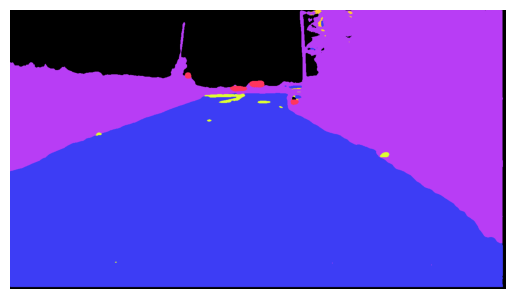

This is epoch 46/60, step 6/6, loss = 0.2220
This is epoch 47/60, step 1/6, loss = 0.1894
This is epoch 47/60, step 2/6, loss = 0.2225
This is epoch 47/60, step 3/6, loss = 0.2033
This is epoch 47/60, step 4/6, loss = 0.1484
This is epoch 47/60, step 5/6, loss = 0.2012
This is epoch 47/60, step 6/6, loss = 0.1781
This is epoch 48/60, step 1/6, loss = 0.2130
This is epoch 48/60, step 2/6, loss = 0.1728
This is epoch 48/60, step 3/6, loss = 0.1885
This is epoch 48/60, step 4/6, loss = 0.3493
This is epoch 48/60, step 5/6, loss = 0.1469
This is epoch 48/60, step 6/6, loss = 0.2430
This is epoch 49/60, step 1/6, loss = 0.2258
This is epoch 49/60, step 2/6, loss = 0.2183
This is epoch 49/60, step 3/6, loss = 0.1671
This is epoch 49/60, step 4/6, loss = 0.1639
This is epoch 49/60, step 5/6, loss = 0.1441
This is epoch 49/60, step 6/6, loss = 0.1703
This is epoch 50/60, step 1/6, loss = 0.2249
This is epoch 50/60, step 2/6, loss = 0.1621
This is epoch 50/60, step 3/6, loss = 0.1445
This is ep

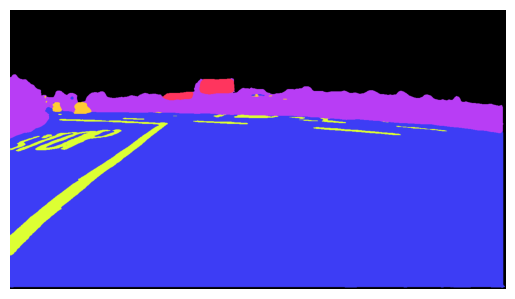

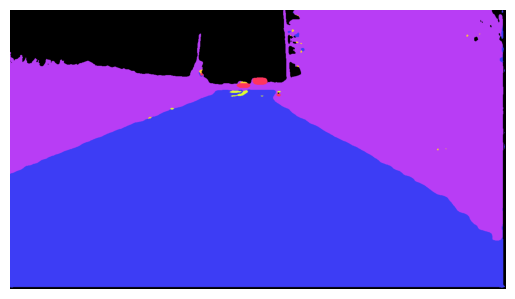

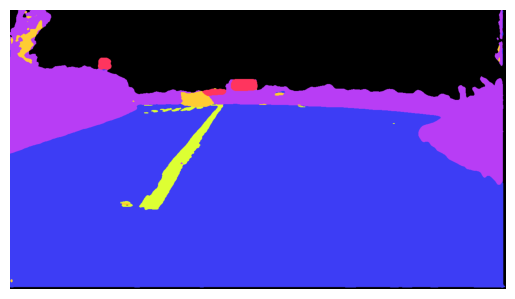

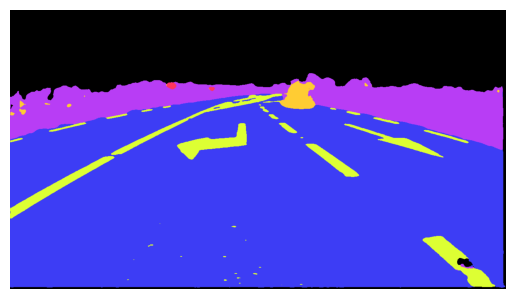

This is epoch 51/60, step 1/6, loss = 0.1597
This is epoch 51/60, step 2/6, loss = 0.2029
This is epoch 51/60, step 3/6, loss = 0.1718
This is epoch 51/60, step 4/6, loss = 0.1335
This is epoch 51/60, step 5/6, loss = 0.1426


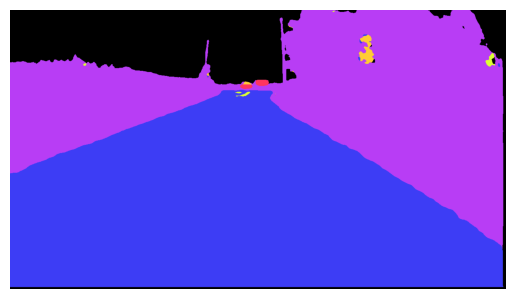

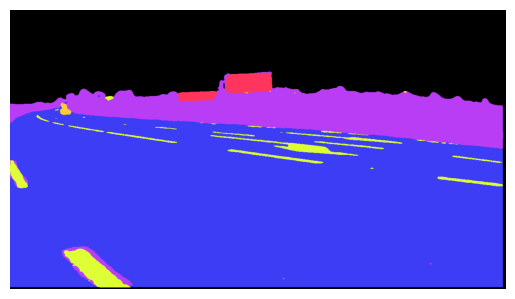

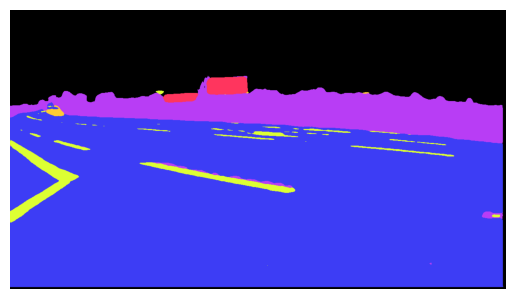

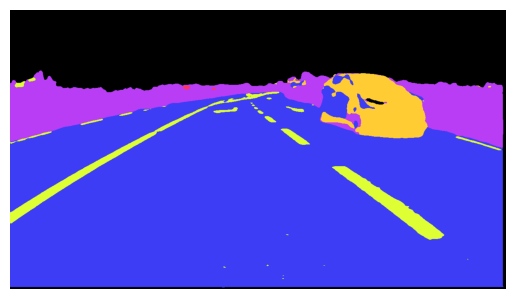

This is epoch 51/60, step 6/6, loss = 0.1199
This is epoch 52/60, step 1/6, loss = 0.1314
This is epoch 52/60, step 2/6, loss = 0.0972
This is epoch 52/60, step 3/6, loss = 0.2291
This is epoch 52/60, step 4/6, loss = 0.1514
This is epoch 52/60, step 5/6, loss = 0.1551
This is epoch 52/60, step 6/6, loss = 0.1492
This is epoch 53/60, step 1/6, loss = 0.1287
This is epoch 53/60, step 2/6, loss = 0.1660
This is epoch 53/60, step 3/6, loss = 0.1732
This is epoch 53/60, step 4/6, loss = 0.3367
This is epoch 53/60, step 5/6, loss = 0.1556
This is epoch 53/60, step 6/6, loss = 0.1155
This is epoch 54/60, step 1/6, loss = 0.1530
This is epoch 54/60, step 2/6, loss = 0.1482
This is epoch 54/60, step 3/6, loss = 0.1448
This is epoch 54/60, step 4/6, loss = 0.1340
This is epoch 54/60, step 5/6, loss = 0.1408
This is epoch 54/60, step 6/6, loss = 0.1265
This is epoch 55/60, step 1/6, loss = 0.1028
This is epoch 55/60, step 2/6, loss = 0.0932
This is epoch 55/60, step 3/6, loss = 0.1222
This is ep

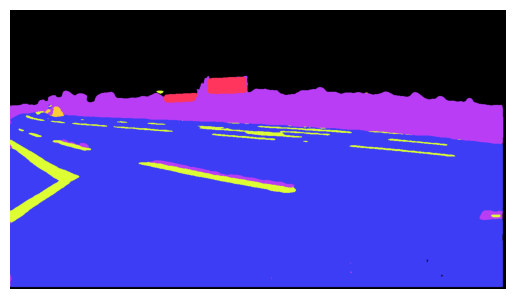

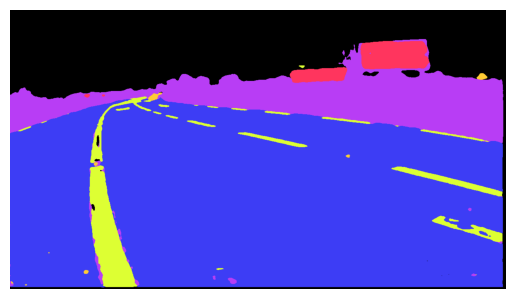

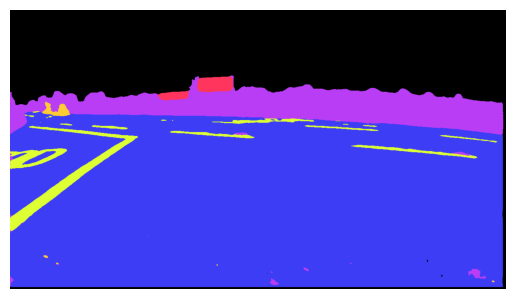

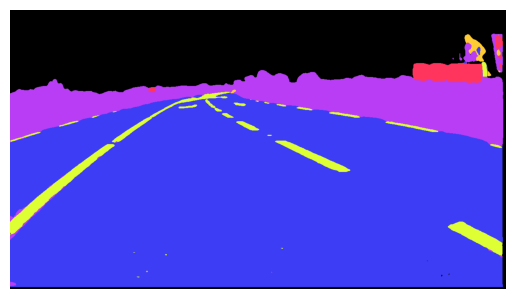

This is epoch 56/60, step 1/6, loss = 0.1820
This is epoch 56/60, step 2/6, loss = 0.1435
This is epoch 56/60, step 3/6, loss = 0.3494
This is epoch 56/60, step 4/6, loss = 0.1474
This is epoch 56/60, step 5/6, loss = 0.1400


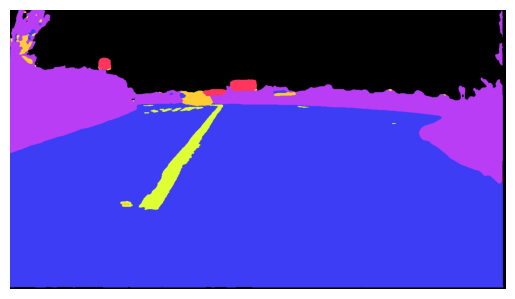

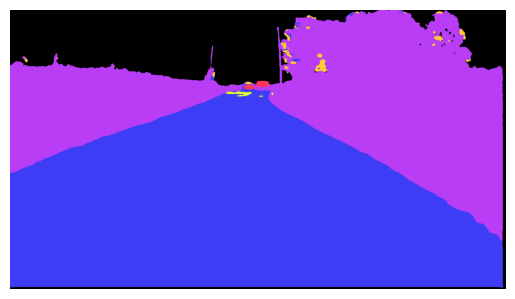

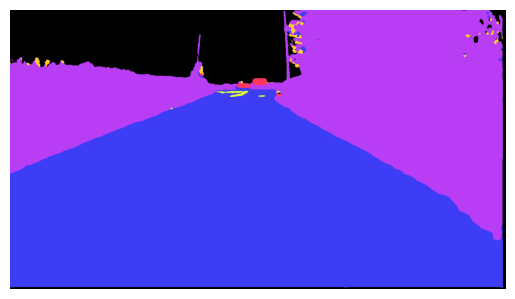

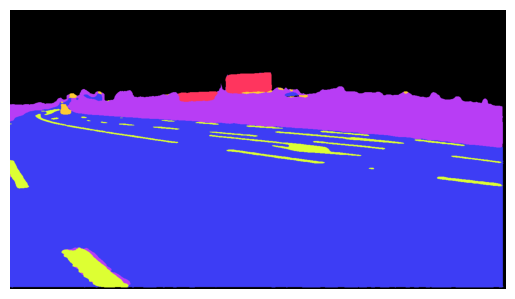

This is epoch 56/60, step 6/6, loss = 0.1840
This is epoch 57/60, step 1/6, loss = 0.1312
This is epoch 57/60, step 2/6, loss = 0.1021
This is epoch 57/60, step 3/6, loss = 0.1236
This is epoch 57/60, step 4/6, loss = 0.1338
This is epoch 57/60, step 5/6, loss = 0.1041
This is epoch 57/60, step 6/6, loss = 0.2113
This is epoch 58/60, step 1/6, loss = 0.1296
This is epoch 58/60, step 2/6, loss = 0.1028
This is epoch 58/60, step 3/6, loss = 0.1559
This is epoch 58/60, step 4/6, loss = 0.1712
This is epoch 58/60, step 5/6, loss = 0.1042
This is epoch 58/60, step 6/6, loss = 0.1372
This is epoch 59/60, step 1/6, loss = 0.1973
This is epoch 59/60, step 2/6, loss = 0.1350
This is epoch 59/60, step 3/6, loss = 0.1662
This is epoch 59/60, step 4/6, loss = 0.1243
This is epoch 59/60, step 5/6, loss = 0.1439
This is epoch 59/60, step 6/6, loss = 0.1125
This is epoch 60/60, step 1/6, loss = 0.1208
This is epoch 60/60, step 2/6, loss = 0.1746
This is epoch 60/60, step 3/6, loss = 0.1078
This is ep

In [16]:
num_epochs = 60 # it should be 50
print("device",device)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # print("images:",images.size())
        # print("labels:",labels.size())
        images = images.to(device)
        labels = labels.to(device)
        labels = torch.argmax(labels, dim=1)  # Shape becomes (batch_size, H, W)
        outputs = model(images)
        if epoch%5==0 and i%5==0:
            predicted_rgb = index_to_rgb(outputs, color_map)
            #print(predicted_rgb)
            display_tensor_image(predicted_rgb[0])
            if(len(predicted_rgb)>1):
                display_tensor_image(predicted_rgb[1])
            if(len(predicted_rgb)>2):
                display_tensor_image(predicted_rgb[2])
            if(len(predicted_rgb)>3):
                display_tensor_image(predicted_rgb[3])
        # print("output shape:",outputs.shape)
        # print("labels shape:",labels.shape)
        # print("output:",outputs[0][0])
        # print("labels:",labels[0][0])
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'This is epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')
print("Completed !!!!!")

device cuda
images: torch.Size([4, 3, 720, 1280])
labels: torch.Size([4, 6, 720, 1280])
outputs: torch.Size([4, 6, 720, 1280])


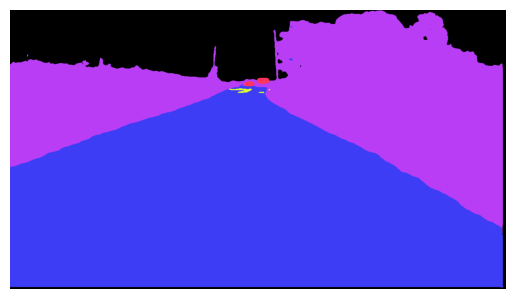

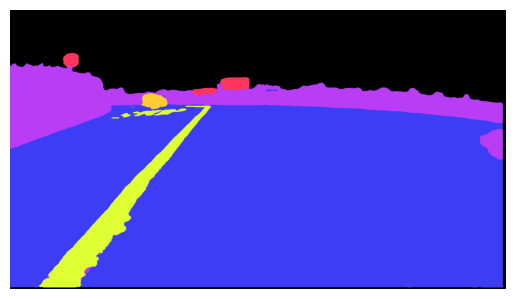

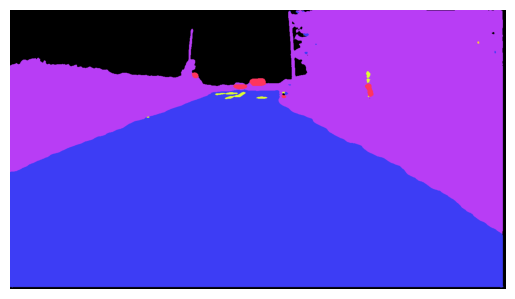

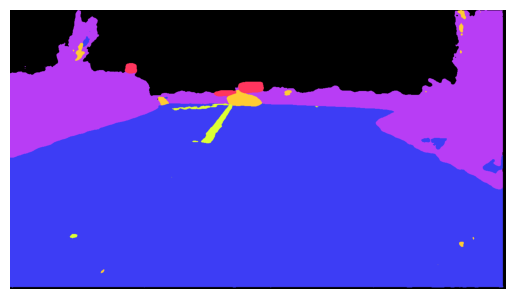

This is epoch 1/1, step 1/6, loss = 0.1329
images: torch.Size([3, 3, 720, 1280])
labels: torch.Size([3, 6, 720, 1280])
outputs: torch.Size([3, 6, 720, 1280])


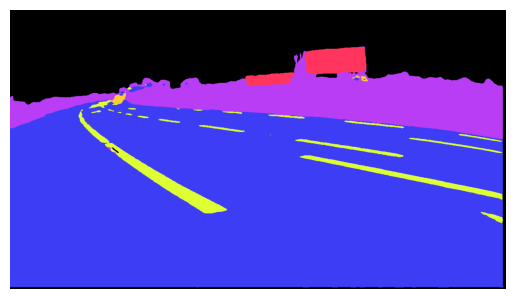

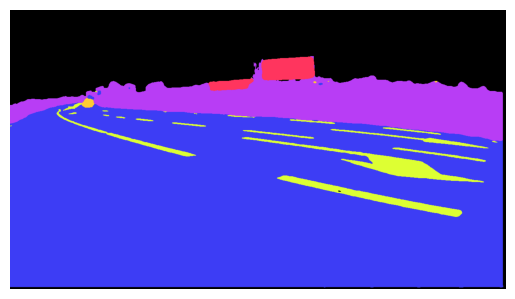

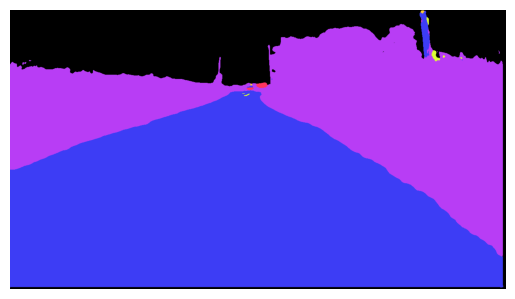

This is epoch 1/1, step 2/6, loss = 0.1356
Completed !!!!!


In [17]:
#test
with torch.no_grad():
    num_epochs = 1
    print("device",device)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(test_loader):
            print("images:",images.size())
            print("labels:",labels.size())
            images = images.to(device)
            labels = labels.to(device)
            labels = torch.argmax(labels, dim=1)  # Shape becomes (batch_size, H, W)
            outputs = model(images)
            print("outputs:",outputs.size())
            predicted_rgb = index_to_rgb(outputs, color_map)
            display_tensor_image(predicted_rgb[0])
            if(len(predicted_rgb)>1):
                display_tensor_image(predicted_rgb[1])
            if(len(predicted_rgb)>2):
                display_tensor_image(predicted_rgb[2])
            if(len(predicted_rgb)>3):
                display_tensor_image(predicted_rgb[3])
            loss = criterion(outputs, labels)
            print(f'This is epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')
            # break;
        # break;
    print("Completed !!!!!")

In [18]:
# # test
# with torch.no_grad():
#     n_correct = 0
#     n_samples = 0
#     n_class_correct = [0 for i in range(10)]
#     n_class_samples = [0 for i in range(10)]
#     for images, labels in test_loader:
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)

#         # fetching the class with the max value out of all the classes, as our output has multiple values i.e, num_classes
#         _, predicted = torch.max(outputs, 1)
#         n_samples +=labels.shape[0]
#         #print(predictions==labels)
#         n_correct += (predicted == labels).sum().item()
#         for i in range(labels.size(0)):
#             label = labels[i]
#             pred = predicted[i]
#             if (label == pred):
#                 n_class_correct[label] +=1
#             n_class_samples[label] += 1
#     acc = 100.0 * n_correct/n_samples
#     print(f'accuracy = {acc}')

#     for i in range(10):
#         acc = 100.0 * n_class_correct[i]/n_class_samples[i]
#         print(f'Accuracy of {classes[i]}: {acc} %')

# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Elapsed time: {elapsed_time:.4f} seconds")